# Лабораторная работа № 4
### Минимальная оценка - 3 балла
### Максимальная оценка - 5 балла
Целью данной работы является изучение временных рядов.
Для успешной сдачи лабораторной работы Вам необходимо предоставить заполненый исходный ноутбук.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
import warnings

In [3]:
warnings.simplefilter("ignore")

## Описание датасета

Датасет (temperatures.csv) содержит информацию о мнимальной температуре на отчётную дату.

In [4]:
df = pd.read_csv('temperatures.csv')
df.head()

,Date,Daily minimum temperatures
0,1/1/1981,20.7
1,1/2/1981,17.9
2,1/3/1981,18.8
3,1/4/1981,14.6
4,1/5/1981,15.8


In [5]:
COLUMN_DATE = 'Date'
COLUMN_MIN_TEMPERATURES = 'Daily minimum temperatures'

In [6]:
# Вообще какие-то температурки начинаются с ?. Буду считать, что они просто минусовые
df[COLUMN_MIN_TEMPERATURES] = df[COLUMN_MIN_TEMPERATURES].str.replace('?', '-', regex=False)

In [7]:
types = {
    COLUMN_DATE: np.datetime64,
    COLUMN_MIN_TEMPERATURES: np.float64 
}

df = df.astype(types).set_index(COLUMN_DATE)

In [8]:
df.head()

,Daily minimum temperatures
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


In [9]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = [10, 5]

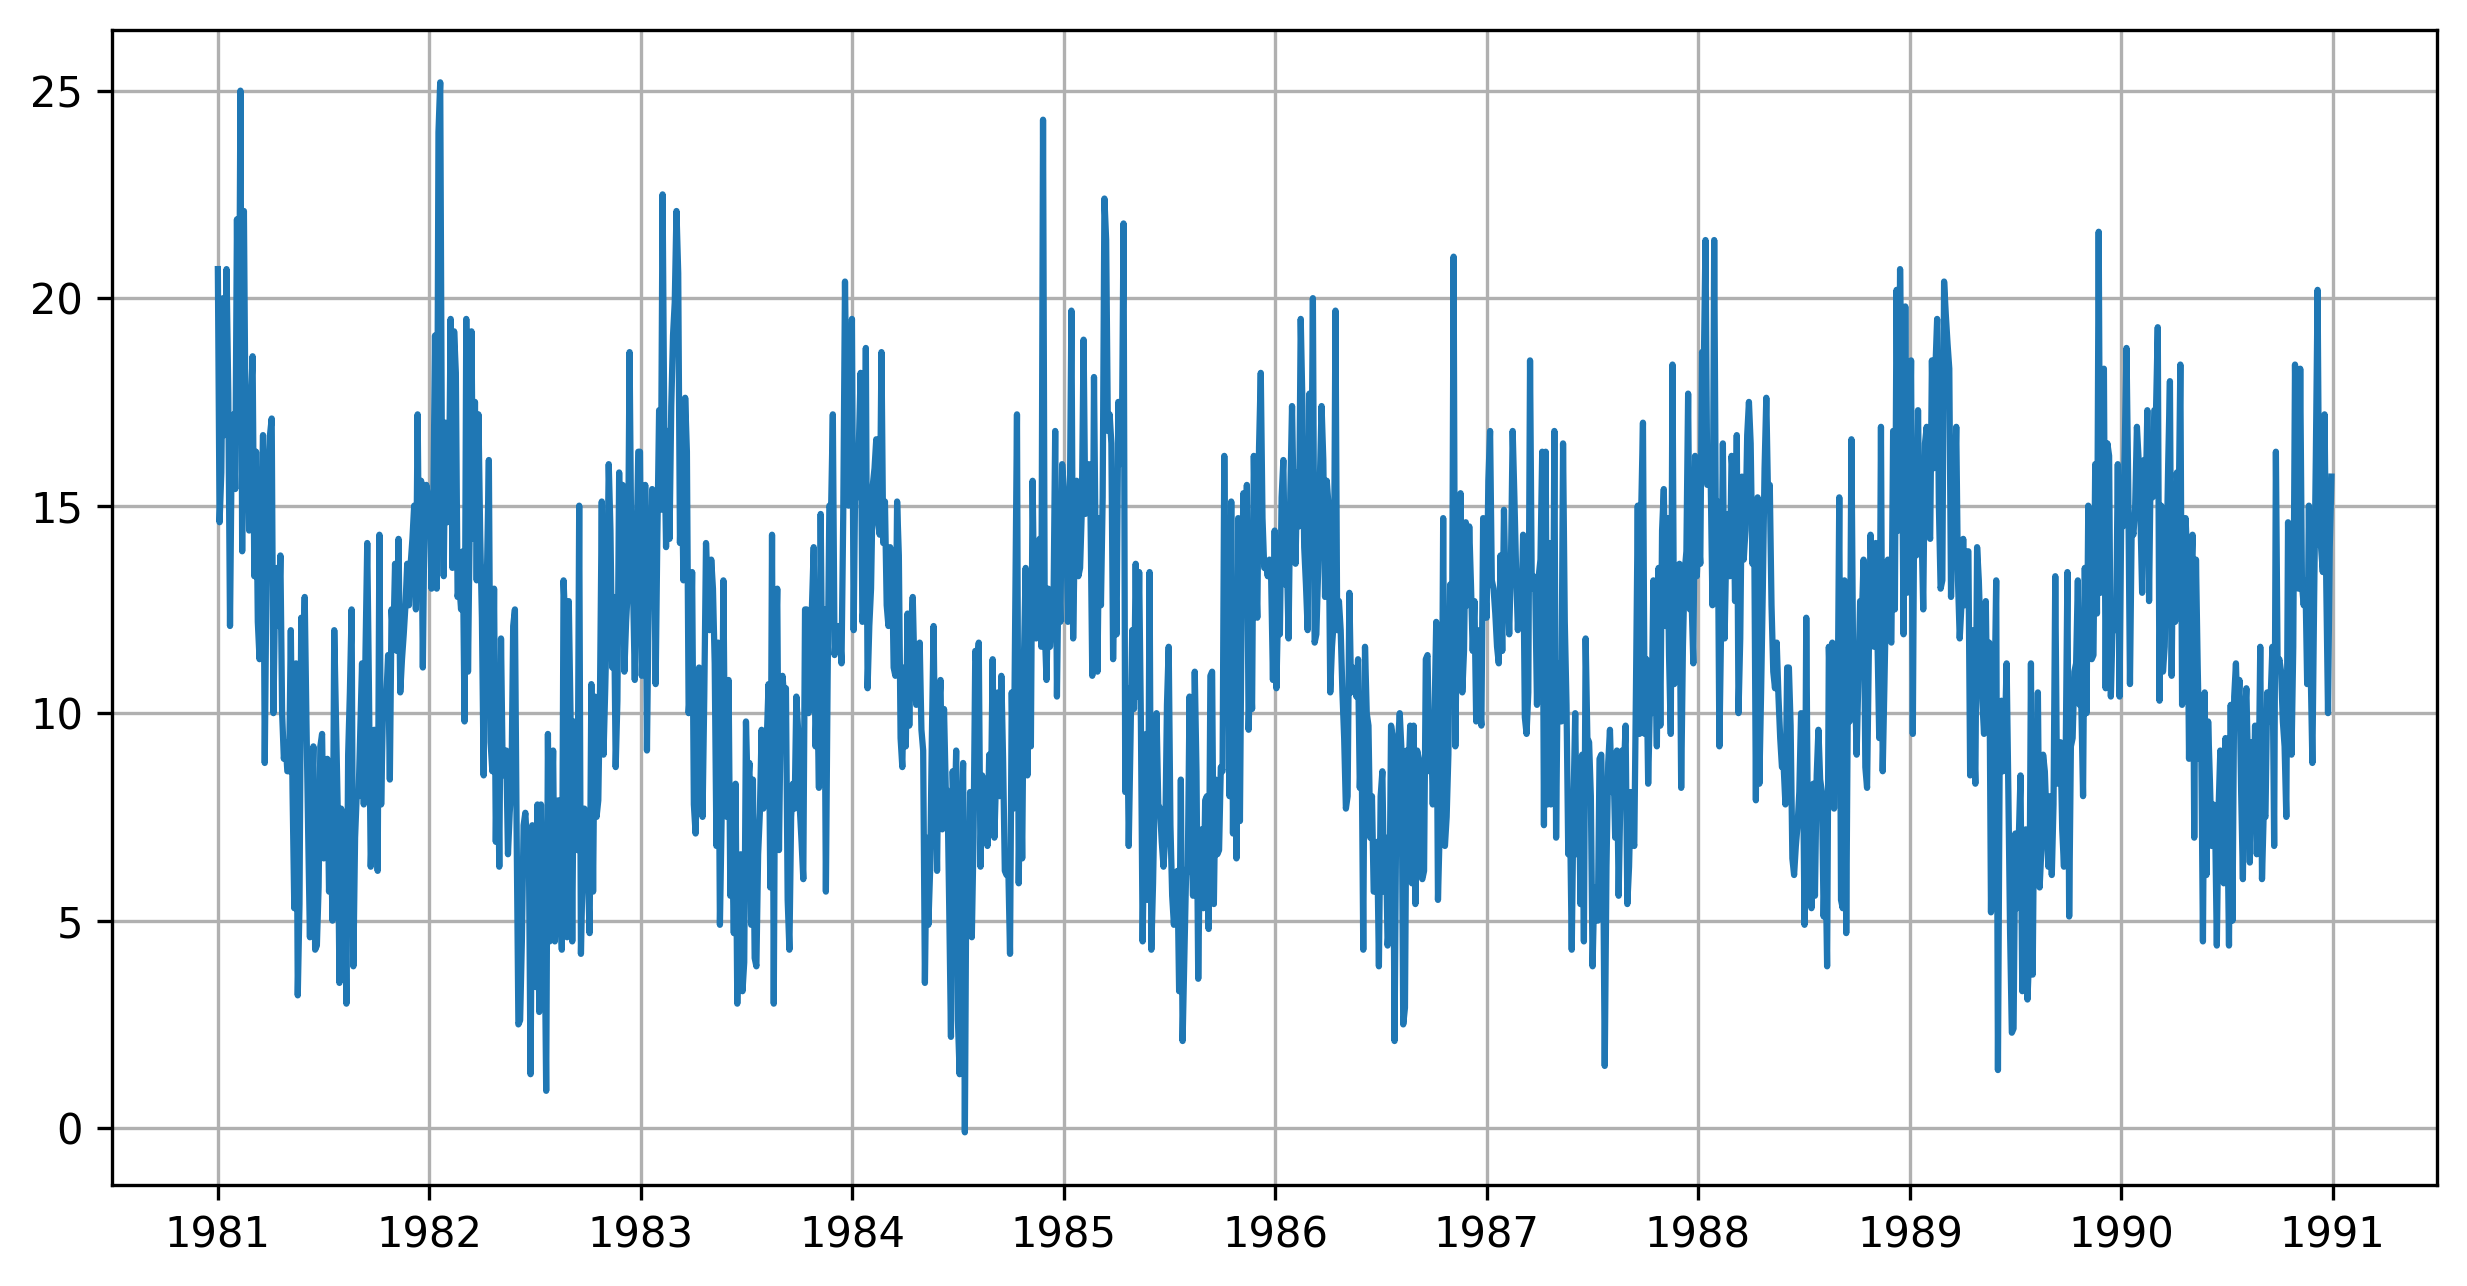

In [10]:
# Построю график (чтобы совсем уж не было каши, то каждое третье значение)
plt.plot(df[COLUMN_MIN_TEMPERATURES][::3])
plt.grid()

## Задание 1 (3 балла)
#### Сгенерировать признаки и сделать предсказания с помощью регрессионных моделей.
Временной ряд – это последовательность значений, описывающих протекающий во времени процесс, измеренных в последовательные моменты времени, обычно через равные промежутки.
Задачу предсказания временного ряда можно решать двумя способами:
1.	Используя «коробочные решения», которые сами определяют сезонность, тренды и т.д.
2.	Самостоятельно генерируя признаки и применяя регрессионные модели.

В данной лабораторной работе упор будет сделан на второй способ.

P.S.: Особое внимание следует уделить тому, что для временного ряда $важно$ сохранять последовательность данных. В противном случае можно столкнуться с ситуацией, когда обучение будет происходить на более поздних данных, а предсказание - на более ранних.

## Задание 1.1
Генерация признаков.

Реализуйте функцию, которая добавляет к исходному датасету следующие колонки:
1. Среднее значение целевой переменной за предыдущие 7 дней до отчётной даты
2. Среднее значение целевой переменной в предыдущем месяце.
3. Среднее значение целевой переменной в этом же месяце год назад.
4. Среднее значение целевой переменной в это же время года, также год назад.

P.S.: следует учитывать, что чисто логически, до завершения текущего дня мы не будем знать значения целевой переменной, а предсказание необходимо сделать на завтра. Это значит, что при генерации признаков необходимо делать отступ в два дня. Например: для предсказания на 09.07.2007, среднее значение целевой переменной за предыдущие 7 дней необходимо считать в период с 01.07.2007 по 07.07.2007

In [11]:
COLUMN_MEAN_LAST_WEEK = 'Mean Last Week'
COLUMN_MEAN_LAST_MONTH = 'Mean Last Month'
COLUMN_MEAN_LAST_YEAR_MONTH = 'Mean Last Year (this month)'
COLUMN_MEAN_LAST_YEAR_SEASON = 'Mean Last Year (this season)'

In [12]:
def helper(df, rule, shift):
    return df.resample(rule).mean().shift(shift) \
        .resample('D').ffill().shift(1) \
        .reindex(df.index)

def my_features(my_dataset):
    df_copy = df.copy()
    
    df_copy[COLUMN_MEAN_LAST_WEEK] = df[COLUMN_MIN_TEMPERATURES] \
        .shift(2) \
        .rolling(7) \
        .mean()
    
    df_copy[COLUMN_MEAN_LAST_MONTH] = helper(df, 'M', 0)
    df_copy[COLUMN_MEAN_LAST_YEAR_MONTH] = helper(df, 'M', 11)
    df_copy[COLUMN_MEAN_LAST_YEAR_SEASON] = helper(df, 'Q-FEB', 3)

    return df_copy

In [13]:
df = my_features(df)

## Задание 1.2 (творческое)
Придумайте, какие ещё признаки можно сгенерировать и добавьте их в предыдущую функцию.

In [14]:
COLUMN_DERIVATIVE = 'Difference 1'
COLUMN_SECOND_DERIVATIVE = 'Difference 2'

In [15]:
def my_features(my_dataset):
    '''
    Добавим первую и вторую производные ряда температур
    '''
    
    df_copy = df.copy()
    
    df_copy[COLUMN_DERIVATIVE] = df[COLUMN_MIN_TEMPERATURES] - df[COLUMN_MIN_TEMPERATURES].shift(1)
    df_copy[COLUMN_SECOND_DERIVATIVE] = df[COLUMN_MIN_TEMPERATURES] - df[COLUMN_MIN_TEMPERATURES].shift(2)
    
    return df_copy

In [16]:
df = my_features(df)

In [17]:
df

,Daily minimum temperatures,Mean Last Week,Mean Last Month,Mean Last Year (this month),Mean Last Year (this season),Difference 1,Difference 2
Date,,,,,,,
1981-01-01,20.7,NaN,NaN,NaN,NaN,NaN,NaN
1981-01-02,17.9,NaN,NaN,NaN,NaN,-2.8,NaN
1981-01-03,18.8,NaN,NaN,NaN,NaN,0.9,-1.9
1981-01-04,14.6,NaN,NaN,NaN,NaN,-4.2,-3.3
1981-01-05,15.8,NaN,NaN,NaN,NaN,1.2,-3.0
...,...,...,...,...,...,...,...
1990-12-27,14.0,13.314286,12.656667,13.951613,14.967778,-0.6,1.1
1990-12-28,13.6,13.300000,12.656667,13.951613,14.967778,-0.4,-1.0
1990-12-29,13.5,13.100000,12.656667,13.951613,14.967778,-0.1,-0.5


## Задание 1.3
Реализуйте свой метод кросс-валидации, который:
1. разделяет выборку на обучающую и тестовую
2. сохраняет временной порядок
3. позволяет сделать пропуск в один день между обучающей и тестовой выборками

In [18]:
def my_cross_val(my_dataset, num_of_split, skip_day=False):
    batch_size = len(my_dataset) // (num_of_split + 2)
    
    i = 2 * batch_size
    while i + batch_size <= len(my_dataset):
        train_min, train_max = 0, i-1
        test_min, test_max = i + int(skip_day), i + batch_size - 1
        
        train = my_dataset.loc[train_min:train_max]
        test = my_dataset.loc[test_min:test_max]
        i += batch_size
        
        yield train.index, test.index

## Задание 1.4
Разделите выборку на обучающую и отложенную тестовую.

С помощью [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) и своей функции кросс-валидации, обучите и подберите оптимальные параметры для следующих алгоритмов:
1. Линейная регрессия
2. Случайный лес
3. Градиентный бустинг

P.S.: Метрику для внутренней оценки (scoring) в RandomizedSearchCV можно выбрать [тут](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring).

In [19]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error

In [20]:
from scipy.stats import uniform

In [21]:
# Удалю теперь строки с NaN
df_copy = df.copy().reset_index().drop(columns=[COLUMN_DATE]).dropna()

In [22]:
X = df_copy.drop([COLUMN_MIN_TEMPERATURES], axis=1)
y = df_copy[COLUMN_MIN_TEMPERATURES]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

In [23]:
parameters = {
    "alpha": uniform(loc=0.1, scale=3.1),
    "l1_ratio": uniform(loc=0, scale=1),
    "max_iter": [100, 200, 300, 500, 600, 900, 1000, 1500] 
}

estimator = ElasticNet(random_state=1)

rscv = RandomizedSearchCV(
    estimator,
    parameters,
    scoring='r2',
    cv=my_cross_val(X_train, 5),
    random_state=1)

rscv.fit(X_train, y_train)
rscv.best_params_

{'alpha': 0.3862496437832732, 'l1_ratio': 0.1862602113776709, 'max_iter': 900}

In [24]:
parameters = {
    "n_estimators": [i for i in range(50, 500, 50)],
    "criterion": ["squared_error", "absolute_error", "poisson"],
    "max_depth": [None, 2, 3, 4, 5, 7],
    "min_samples_split": [2, 3, 4, 5] 
}

estimator = RandomForestRegressor(random_state=1)

rfcv = RandomizedSearchCV(
    estimator,
    parameters,
    scoring='r2',
    cv=my_cross_val(X_train, 5),
    random_state=1)

rfcv.fit(X_train,y_train)
rfcv.best_params_

{'n_estimators': 150,
 'min_samples_split': 4,
 'max_depth': 5,
 'criterion': 'absolute_error'}

In [25]:
params = {
    "learning_rate": uniform(loc=0.1, scale=1.5),
    "n_estimators": [i for i in range(100, 500, 50)],
    "subsample": [1.0, 0.5],
    "criterion": ['friedman_mse', 'squared_error'],
    "max_depth": [None, 2, 3, 4, 5],
    "min_samples_split": [2, 3, 4, 5] 
}

estimator = GradientBoostingRegressor(random_state=1)

gbrscv = RandomizedSearchCV(
    estimator,
    parameters,
    scoring='r2',
    cv=my_cross_val(X_train, 5),
    random_state=1)

gbrscv.fit(X_train, y_train)
gbrscv.best_params_

{'n_estimators': 450,
 'min_samples_split': 2,
 'max_depth': 4,
 'criterion': 'squared_error'}

## Задание 1.5
Сравните результаты работы обученных моделей на отложенной тестовой выборке с помощью графиков и метрик (R2 и любой другой на ваш выбор).

In [26]:
lr_predict = rscv.predict(X_test)
rf_predict = rfcv.predict(X_test)
gb_predict = gbrscv.predict(X_test)

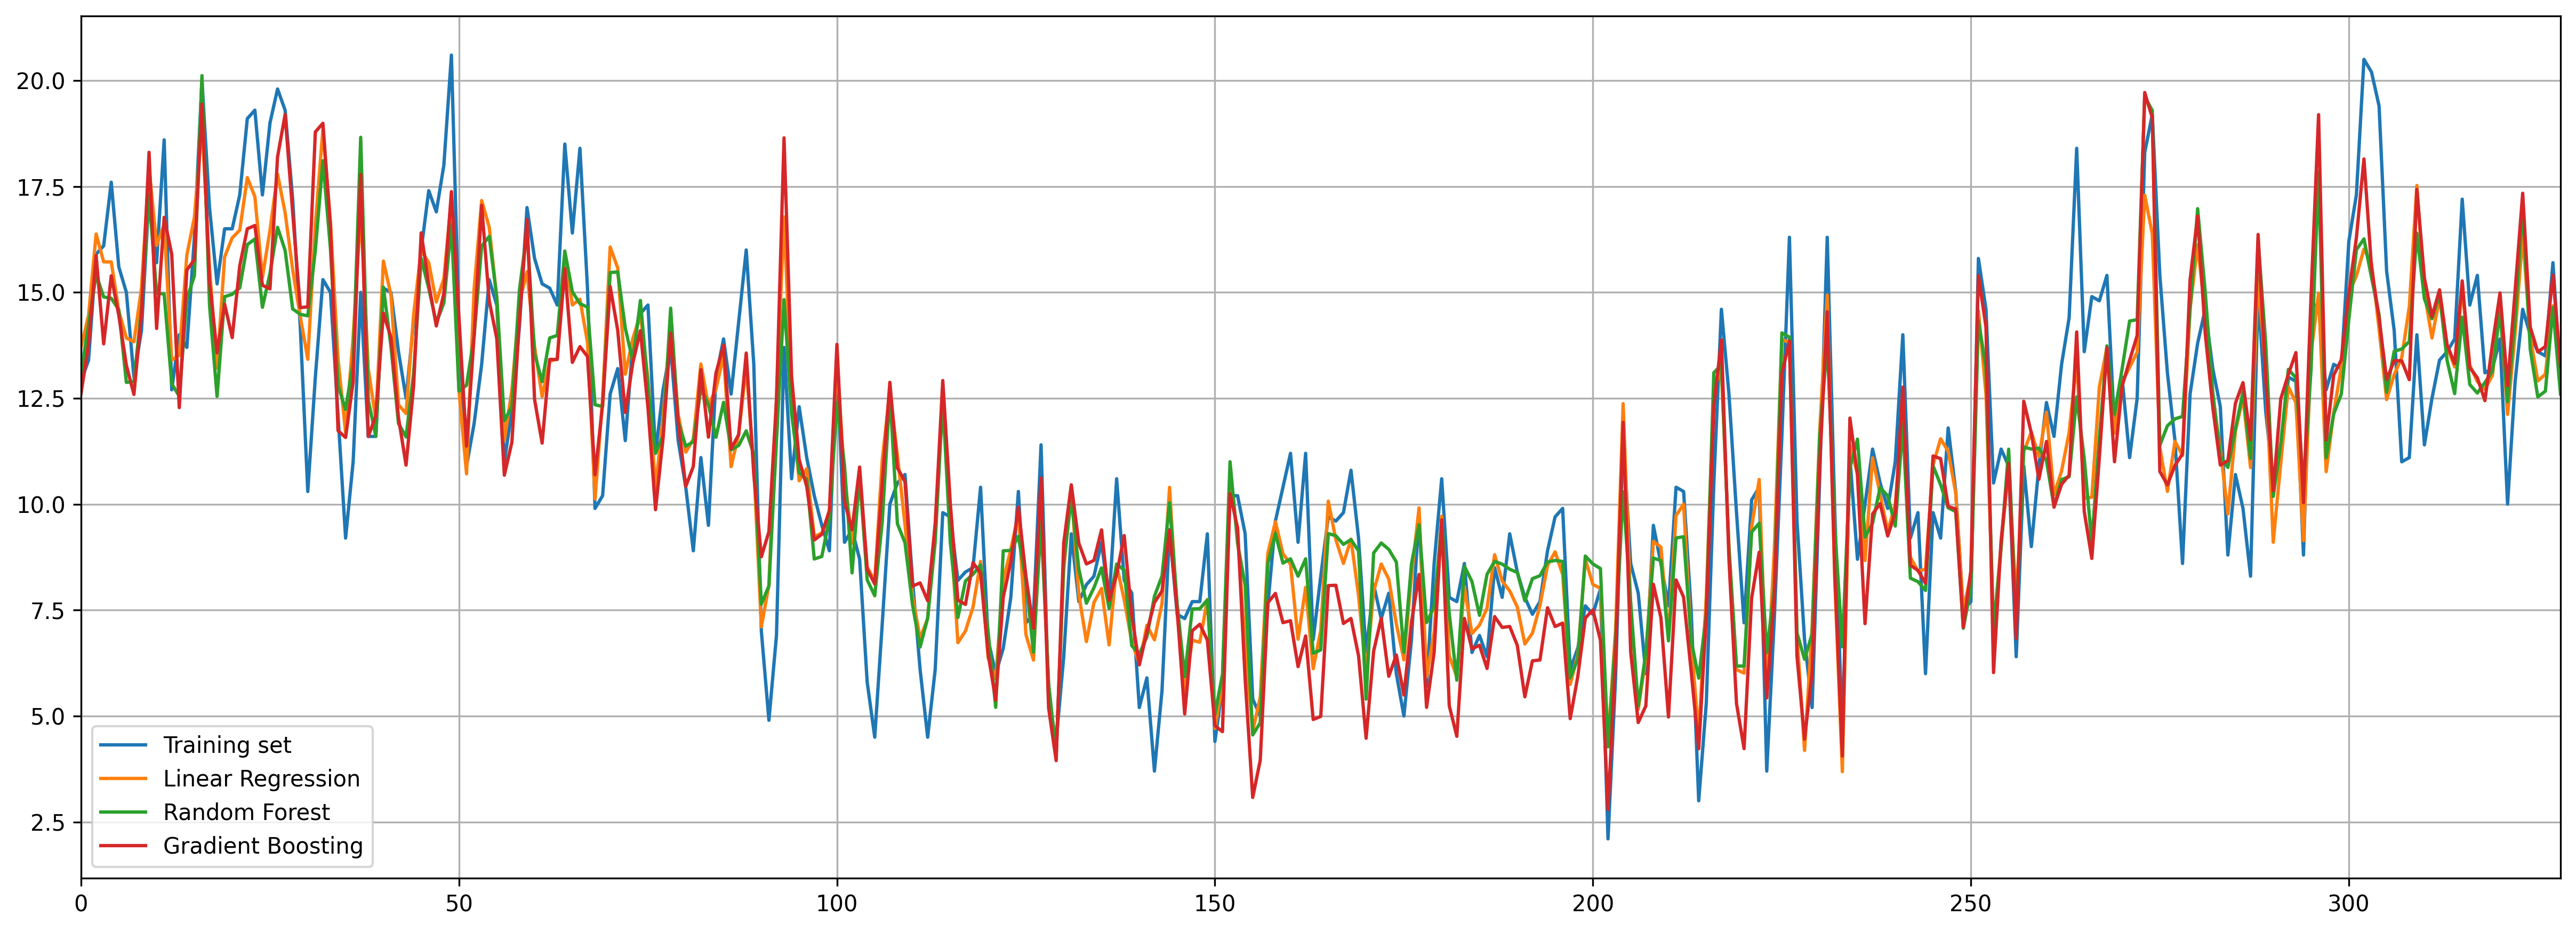

In [27]:
plt.figure(figsize=(20, 7))

plt.plot(y_test.values, label='Training set')
plt.plot(lr_predict, label='Linear Regression')
plt.plot(rf_predict, label='Random Forest')
plt.plot(gb_predict, label='Gradient Boosting')

plt.legend(loc='best')
plt.margins(x=0, y=0.05)
plt.grid()

## Задание 2 (2 балла)
Установите и разберитесь как работает [Prophet](https://facebook.github.io/prophet/docs/quick_start.html#python-api).
<br>Решите эту же задачу с помощью него.

In [28]:
from prophet import Prophet
from prophet.diagnostics import performance_metrics, cross_validation

In [29]:
columns={
    COLUMN_DATE: "ds",
    COLUMN_MIN_TEMPERATURES: 'y' 
}

df_prophet = df.copy().reset_index()[[COLUMN_DATE, COLUMN_MIN_TEMPERATURES]] \
    .sort_values(by=COLUMN_DATE).rename(columns=columns)

estimator = Prophet(daily_seasonality=True)
estimator.fit(df_prophet)

test = df_prophet.sample(frac=0.2)
predict = estimator.predict(test)

23:18:30 - cmdstanpy - INFO - Chain [1] start processing
23:18:31 - cmdstanpy - INFO - Chain [1] done processing


In [30]:
cv = cross_validation(estimator, initial='2920 days', horizon='730 days')
perf_metrics = performance_metrics(cv)
perf_metrics.head()

  0%|          | 0/1 [00:00<?, ?it/s]

23:18:32 - cmdstanpy - INFO - Chain [1] start processing
23:18:32 - cmdstanpy - INFO - Chain [1] done processing


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,73 days,7.347892,2.710700,2.196737,0.139668,0.131114,0.136277,0.794521
1,74 days,7.333215,2.707991,2.189053,0.139101,0.131114,0.135745,0.794521
2,75 days,7.306530,2.703059,2.177279,0.138521,0.131114,0.135092,0.794521
3,76 days,7.391664,2.718762,2.191347,0.140701,0.131114,0.136618,0.794521
4,77 days,7.506572,2.739812,2.221973,0.143364,0.133442,0.138915,0.794521


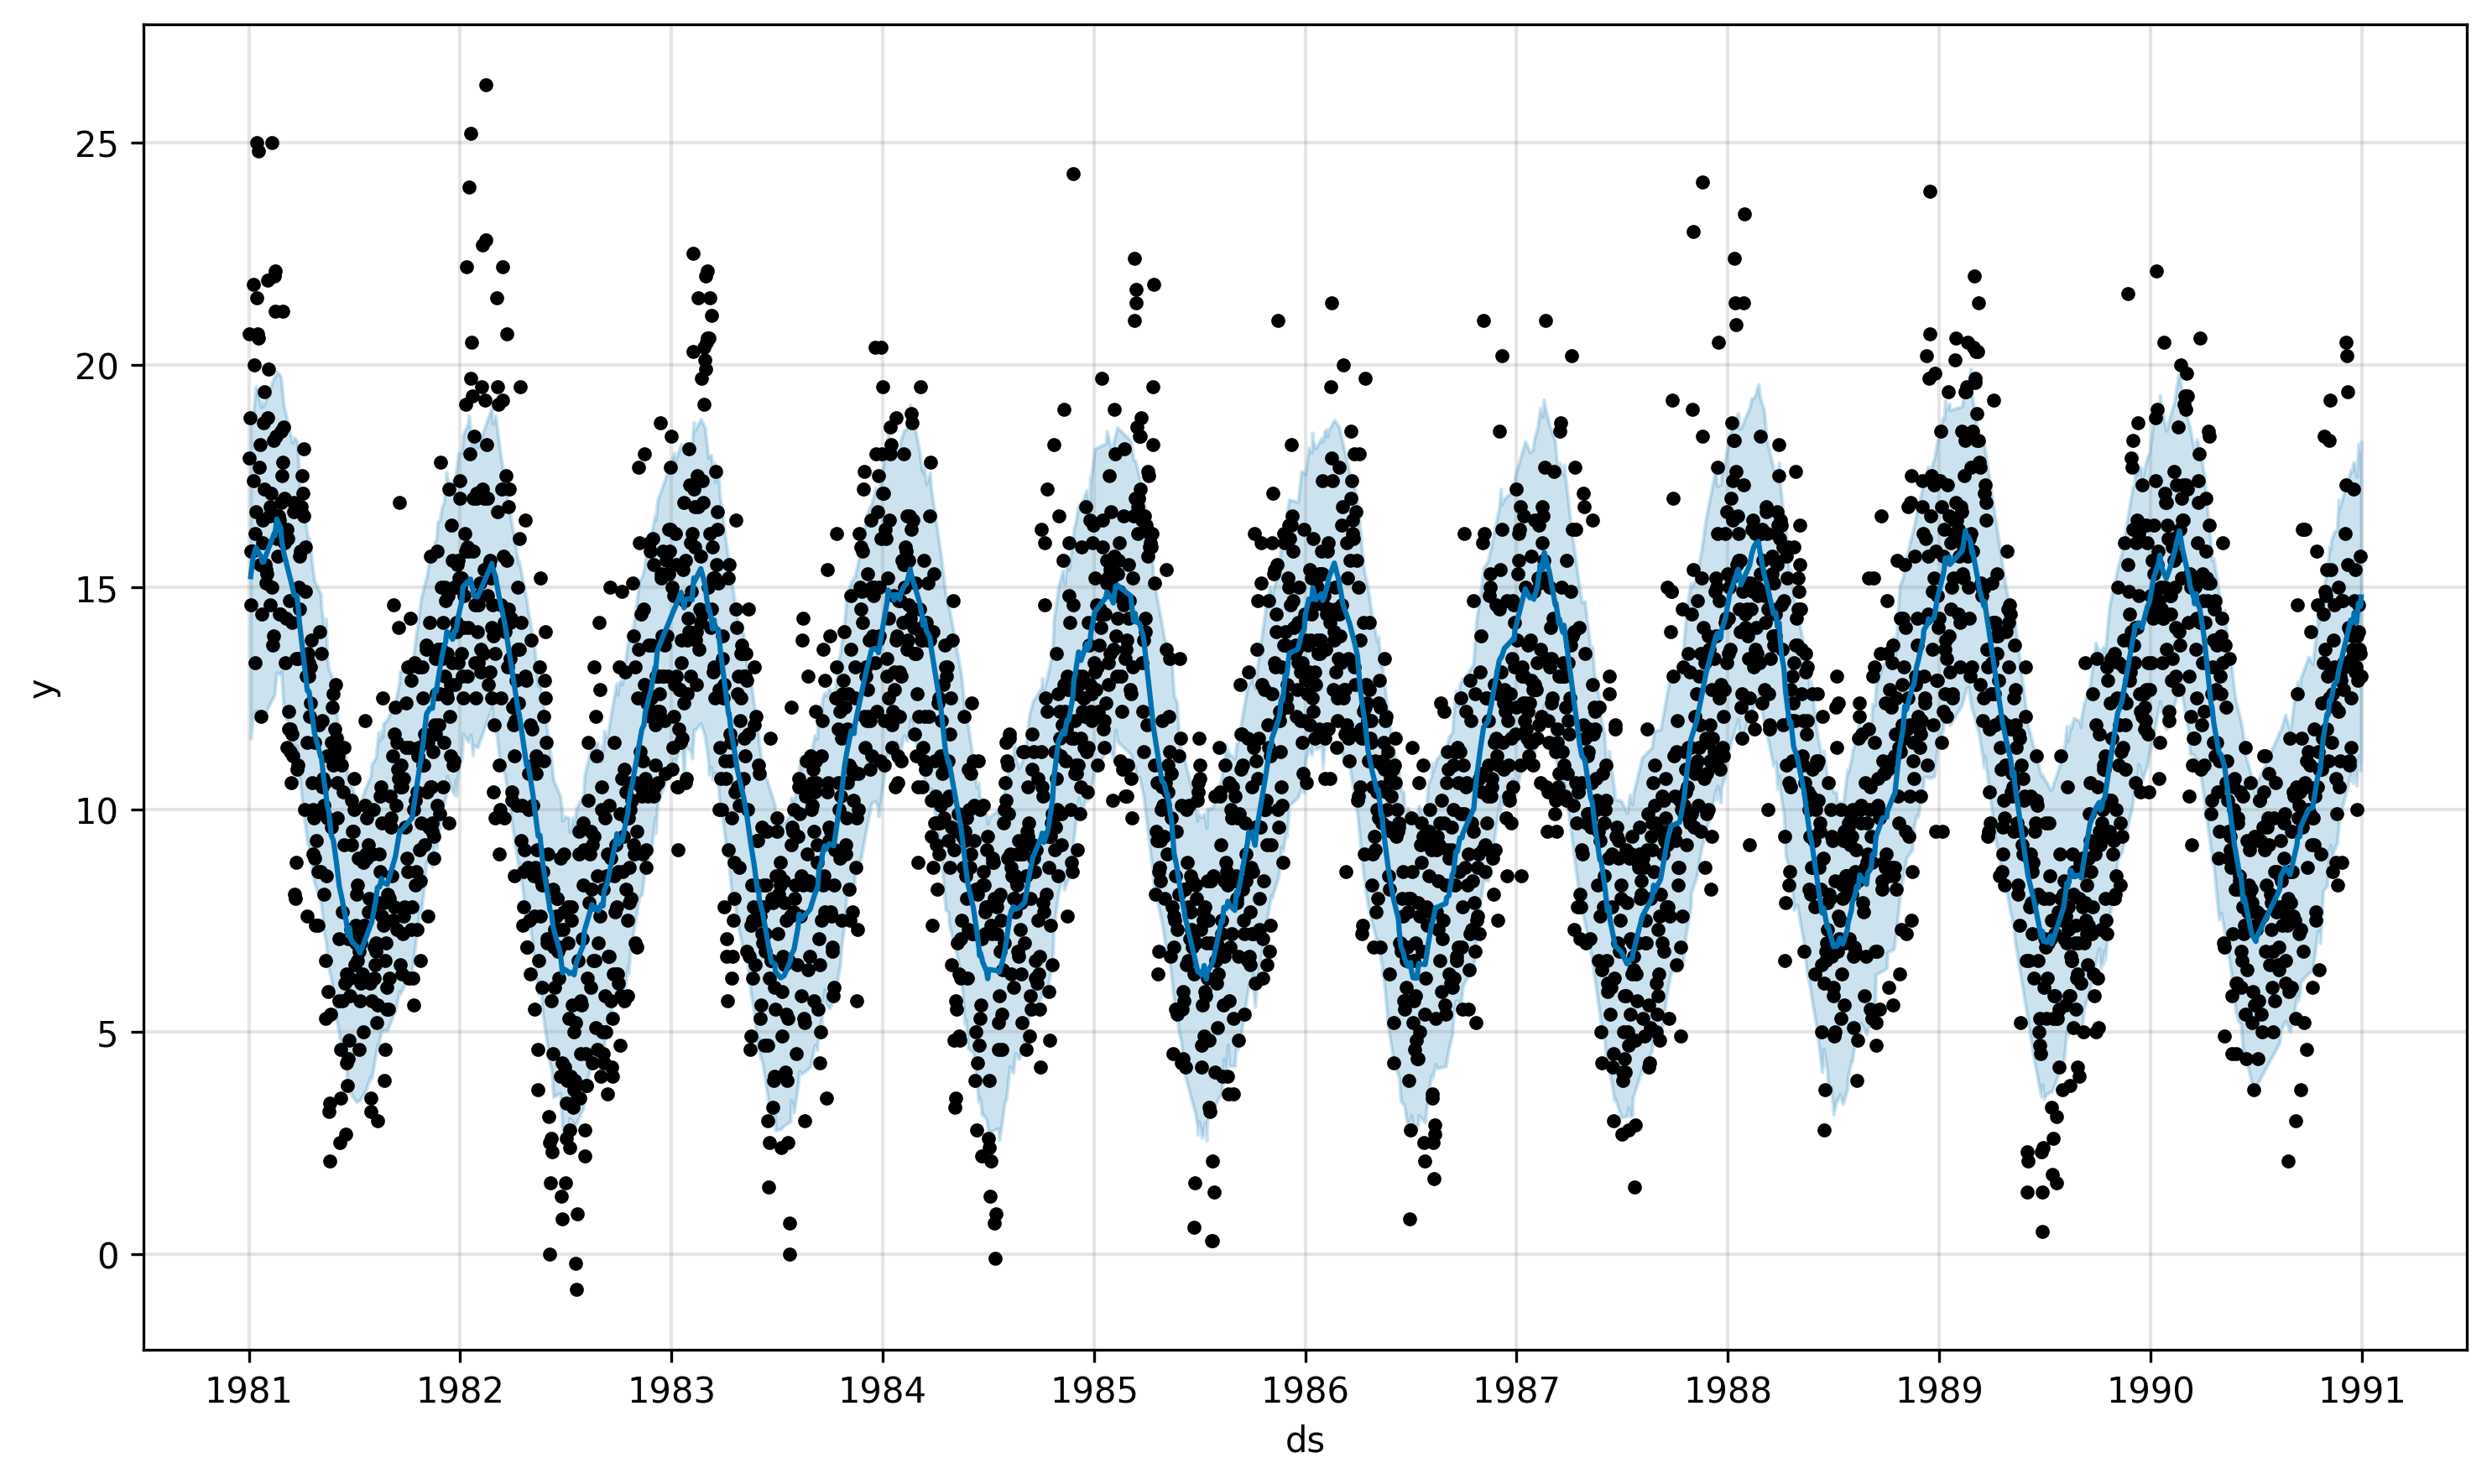

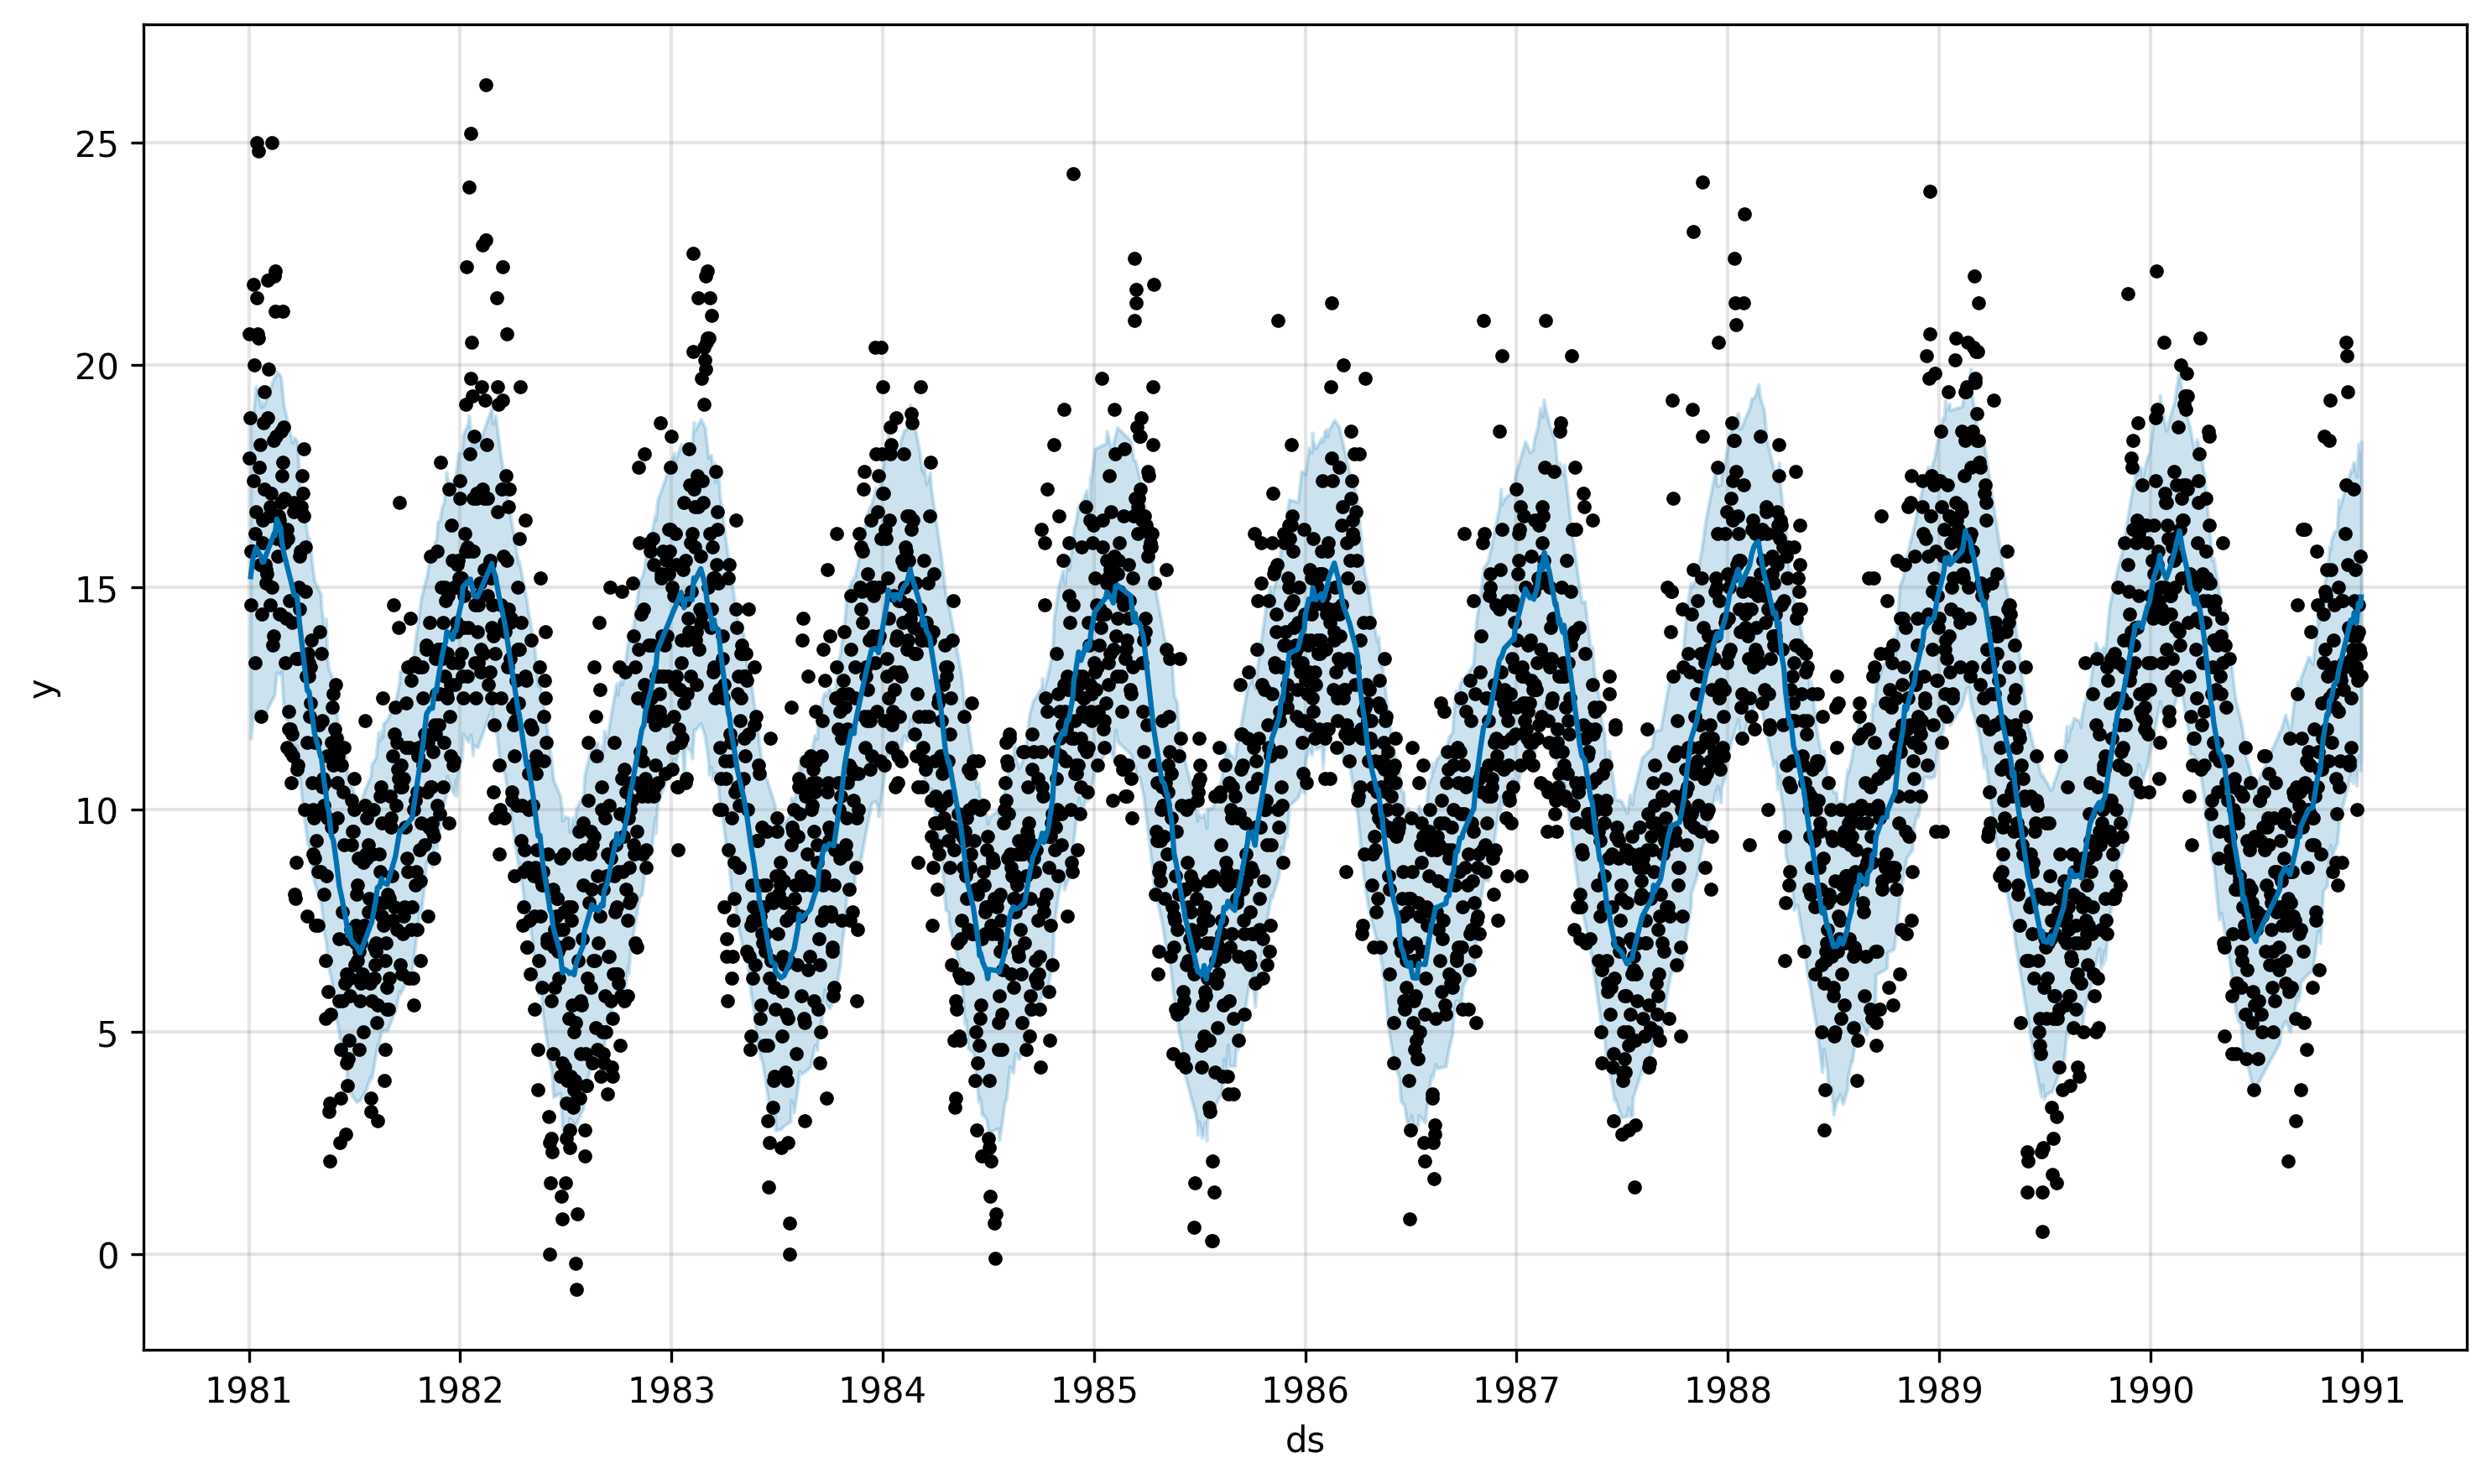

In [31]:
estimator.plot(predict)